In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils import axes_dict, plot_some, plot_history
from stardist import fill_label_holes, random_label_cmap
from stardist import Config, StarDist, StarDistData

np.random.seed(42)
lbl_cmap = random_label_cmap()

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imageri

In [2]:
X = sorted(glob('/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/images/*.tif'))
Y = sorted(glob('/data/u934/service_imagerie/v_kapoor/HEARD/UNet-training/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))


In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))


In [4]:
X = [normalize(x,1,99.8) for x in tqdm(X)]
Y = [fill_label_holes(y.astype(int)) for y in tqdm(Y)]




100%|██████████| 84/84 [00:06<00:00, 13.06it/s] 


In [5]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = int(round(0.15 * len(X)))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 



print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))
print(X[0].shape[0])

number of images:  84
- training:        71
- validation:      13
512


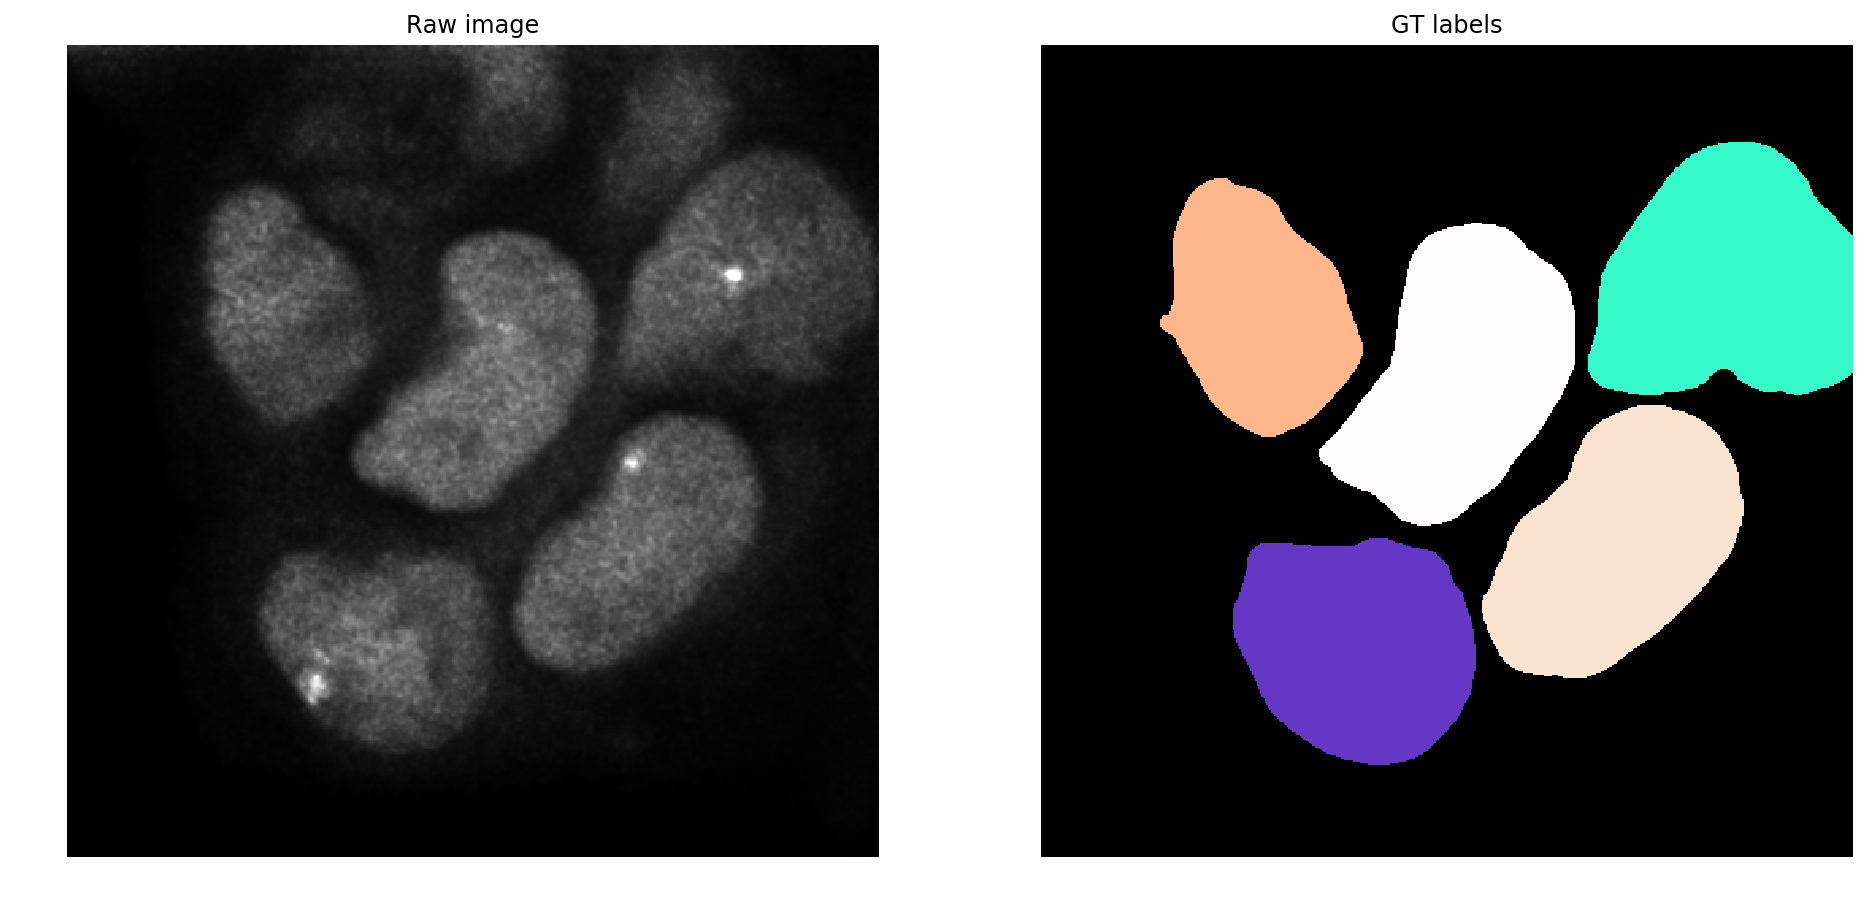

In [6]:
i = 9
img, lbl = X[i], Y[i]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [7]:
np.random.seed(42)
data = StarDistData(X,Y,batch_size=1,n_rays=32,patch_size=(512,512),shape_completion=False)

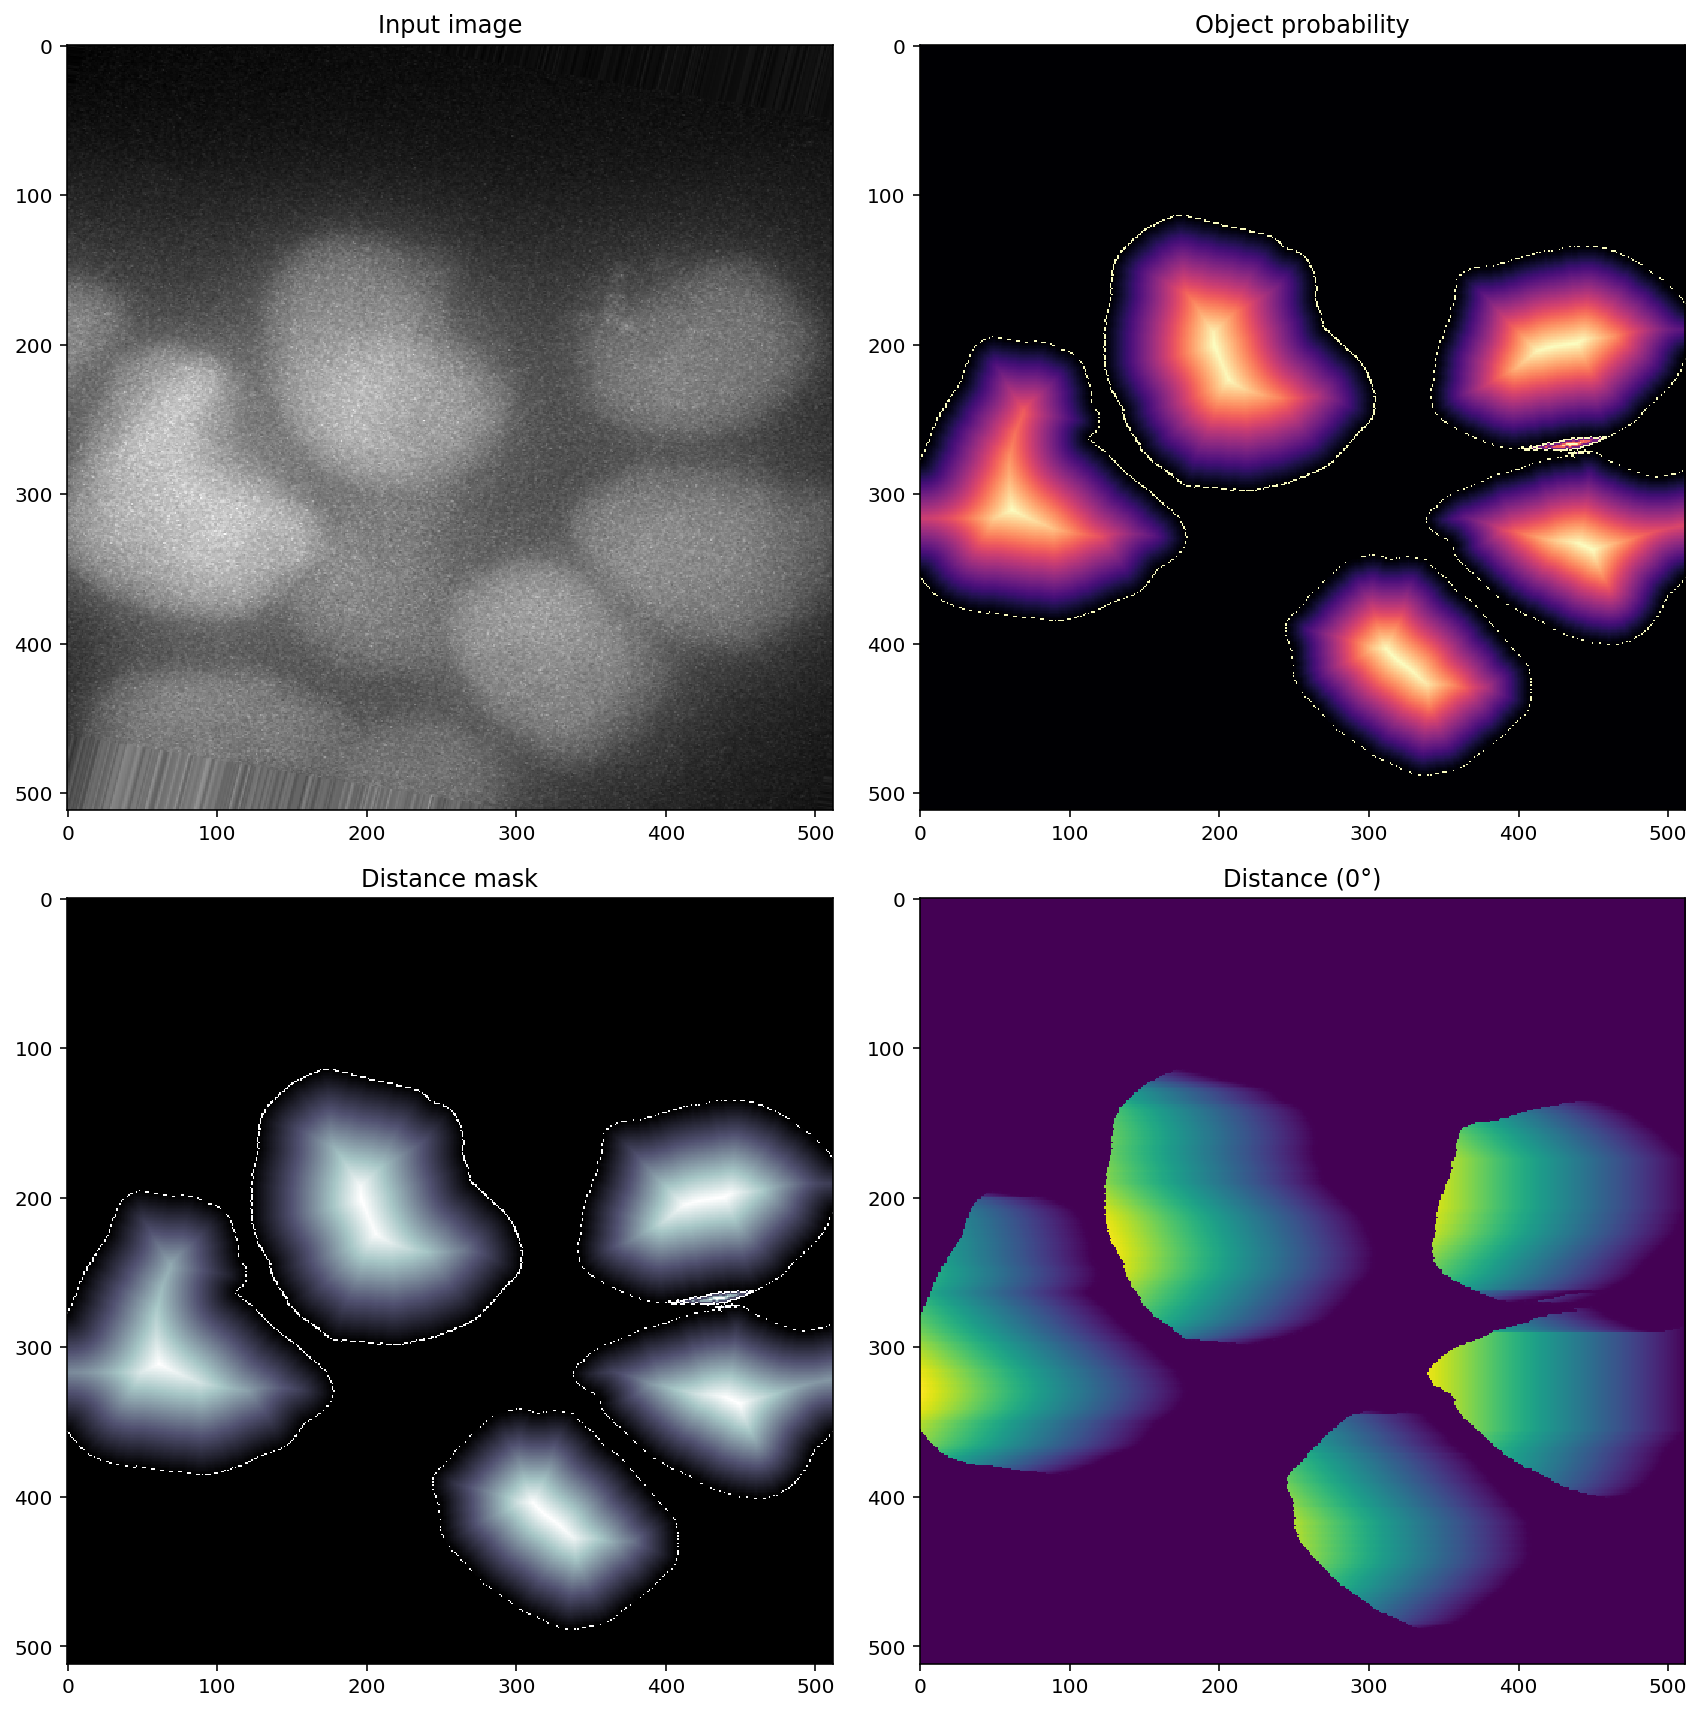

In [8]:
(img,dist_mask), (prob,dist) = data[0]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

In [9]:
print(Config.__doc__)

Configuration for a :class:`StarDist` model.

    Parameters
    ----------
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convolution kernels (feature channels) for first U-Net layer.
        Doubled after each down-sampling layer.
    net_conv_after_unet : int
        Number of extra convolution layers after U-Net (0 to disable).
    train_shape_completion : bool
        Train model to predict complete shapes for partially visible objects at image boundary.
    tr

In [10]:
conf = Config(train_batch_size=10, train_shape_completion=False, train_patch_size = (512,512), train_epochs = 50, train_steps_per_epoch = 100)
print(conf)
vars(conf)

Config(n_channel_in=1, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), train_batch_size=10, train_checkpoint='weights_best.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=50, train_learning_rate=0.0003, train_patch_size=(512, 512), train_reduce_lr={'patience': 10, 'factor': 0.5}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_kernel_size=(3, 3), unet_n_depth=3, unet_n_filter_base=32)


{'n_channel_in': 1,
 'n_rays': 32,
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'train_batch_size': 10,
 'train_checkpoint': 'weights_best.h5',
 'train_completion_crop': 32,
 'train_dist_loss': 'mae',
 'train_epochs': 50,
 'train_learning_rate': 0.0003,
 'train_patch_size': (512, 512),
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_shape_completion': False,
 'train_steps_per_epoch': 100,
 'train_tensorboard': True,
 'unet_kernel_size': (3, 3),
 'unet_n_depth': 3,
 'unet_n_filter_base': 32}

In [11]:
model = StarDist(conf, name='StemCellWithoutShapeCompletion', basedir='models')

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/stardist/model.py:272: UserWarning: output path for model already exists, files may be overwritten: /data/u934/service_imagerie/v_kapoor/anaconda2/bin/StarDist/StardistforCurie/models/StemCellWithoutShapeCompletion
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [12]:
history = model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

Epoch 1/50
100/100 [==============================] - 235s 2s/step - loss: 5.4692 - prob_loss: 0.4419 - dist_loss: 5.0273 - val_loss: 3.6763 - val_prob_loss: 0.3351 - val_dist_loss: 3.3412
Epoch 2/50
100/100 [==============================] - 213s 2s/step - loss: 3.3861 - prob_loss: 0.3292 - dist_loss: 3.0568 - val_loss: 3.2651 - val_prob_loss: 0.2989 - val_dist_loss: 2.9662
Epoch 3/50
100/100 [==============================] - 216s 2s/step - loss: 3.3168 - prob_loss: 0.3617 - dist_loss: 2.9551 - val_loss: 3.3849 - val_prob_loss: 0.3823 - val_dist_loss: 3.0025
Epoch 4/50
100/100 [==============================] - 217s 2s/step - loss: 3.1856 - prob_loss: 0.2647 - dist_loss: 2.9209 - val_loss: 2.9349 - val_prob_loss: 0.2012 - val_dist_loss: 2.7338
Epoch 5/50
100/100 [==============================] - 215s 2s/step - loss: 2.7315 - prob_loss: 0.2215 - dist_loss: 2.5100 - val_loss: 2.6668 - val_prob_loss: 0.2227 - val_dist_loss: 2.4441
Epoch 6/50
100/100 [==============================] - 2

100/100 [==============================] - 210s 2s/step - loss: 1.1073 - prob_loss: 0.1708 - dist_loss: 0.9365 - val_loss: 1.4287 - val_prob_loss: 0.1991 - val_dist_loss: 1.2295
Epoch 45/50
100/100 [==============================] - 211s 2s/step - loss: 1.1136 - prob_loss: 0.1764 - dist_loss: 0.9371 - val_loss: 1.4186 - val_prob_loss: 0.1875 - val_dist_loss: 1.2311
Epoch 46/50
100/100 [==============================] - 206s 2s/step - loss: 1.0552 - prob_loss: 0.1687 - dist_loss: 0.8865 - val_loss: 1.4293 - val_prob_loss: 0.1822 - val_dist_loss: 1.2471
Epoch 47/50
100/100 [==============================] - 214s 2s/step - loss: 1.0582 - prob_loss: 0.1707 - dist_loss: 0.8875 - val_loss: 1.4025 - val_prob_loss: 0.1826 - val_dist_loss: 1.2198
Epoch 48/50
100/100 [==============================] - 221s 2s/step - loss: 1.0381 - prob_loss: 0.1669 - dist_loss: 0.8712 - val_loss: 1.3929 - val_prob_loss: 0.1833 - val_dist_loss: 1.2096
Epoch 49/50
100/100 [==============================] - 210s 2s

['dist_loss', 'loss', 'lr', 'prob_loss', 'val_dist_loss', 'val_loss', 'val_prob_loss']


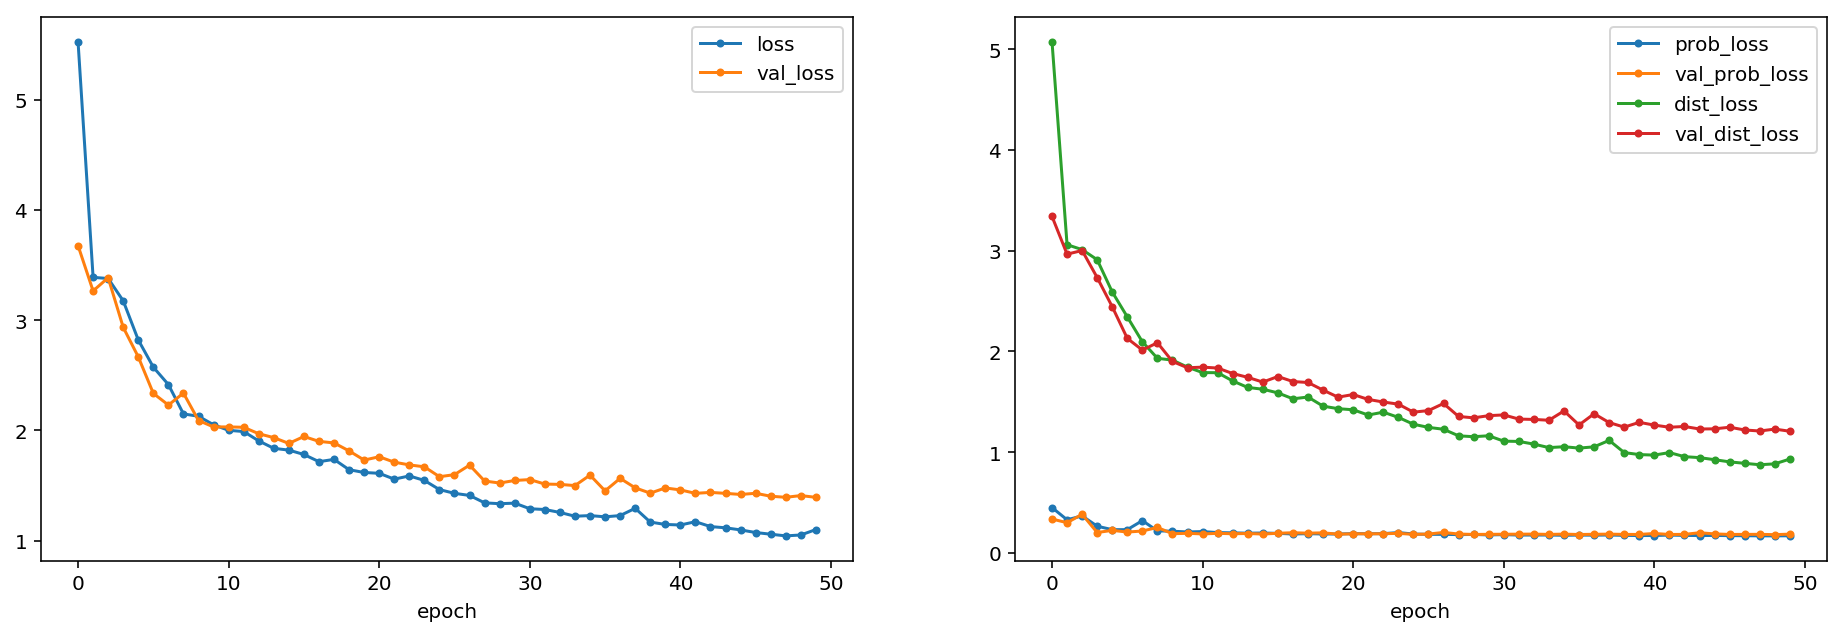

In [13]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['prob_loss','val_prob_loss','dist_loss','val_dist_loss']);